# Model Tuning

This notebook includes a hyperparameter tuning and feature selection exercise for the top performing classifier. The objective is to narrow down which features and hyperparameters will be used in the next phase of scaling to jurisdictional scale maps.

* Which features have the greatest influence in the predictions?
    - CatBoost's feature importance method
    - Shap value analysis
* Which features are correlated?
* Which hyperparameters should be used?
    - Catboost's random search method
* How does the resulting/tuned model compare with the baseline?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src/')
import ptype_prepare_data as pp
import ptype_run_preds as rp
import score_classifier as score
import ptype_visualize as viz
import pandas as pd
import pickle
from datetime import datetime
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import shap
shap.initjs()

%load_ext autoreload
%autoreload 2

# Feature Analysis
Evaluate feature importance for the top performing MVP model (Catboost). Training with only the most important features will help to reduce overfitting and training time, while improving accuracy by removing misleading data and noise. Feature importance values are normalized so that the sum of importances of all features is equal to 100.   
  
Index `0`: slope  
Index `1:3`: s1  
Index `3:13`: s2  
Index `13:77`: TML features (`77` is TML tree probability)

In [5]:
def feature_selection(model, feat_count):
    
    '''
    calculates the importance of features for a given model
    '''
    
    filename = f'../models/{model}.pkl'
    with open(filename, 'rb') as file:
        model = pickle.load(file)

    # calculate the feature importance 
    feat_import = model.get_feature_importance(prettified=True)
    feat_import = feat_import.astype({'Feature Id': int})
    
    # x features describe x% of the importance?
    tops = feat_import.sort_values(by='Importances', ascending=False)[:feat_count]
    percentage = tops.Importances.sum()
    print(f'{feat_count} features explain {round(percentage,2)}%')
    
    # filter to only TML feats (anything after index 13) then get the top
    tml = feat_import[feat_import['Feature Id'] >= 13]
    top_tml = tml.sort_values(by='Importances', ascending=False)[:feat_count]
    
    # print top TML feats w/ original indices 0-65
    tml_indices = [i - 13 for i in sorted(list(top_tml['Feature Id']))]
    print(tml_indices)
    
    return feat_import, top_tml


def visualize_importance(model, feature_importance, figsize):
    
    plt.figure(figsize=figsize) 

    sns.barplot(y='Feature Id', 
                x='Importances', 
                data=feature_importance,
                orient='h', 
                palette="Greens_d")
    
    plt.title(f'Feature Importance for {model}')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature');
#     plt.xticks(rotation=80, ha='right');
    
    return None
    

## Visualize Feature Importance

The first visualization illustrates the feature importance scores for all features used in the selected model. The second visualizations illustrates the feature importance scores for the features that explain 80-90% of the importance for the same model OR the top 15 ranked features.

## West Africa


In [23]:
# train a model on scaled data to avoid biasing feature importance
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=True)

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


In [24]:
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v17', verbose=True)

y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v17_scaled')


X_train: (471, 14, 14, 78) X_test: (233, 14, 14, 78), y_train: (471, 14, 14), y_test: (233, 14, 14)
Reshaped X_train: (92316, 78) X_test: (45668, 78), y_train: (92316,), y_test: (45668,)
The data was scaled to: Min -1.7546663284301758 -> -1.0000000000000002, Max 3.276700019836426 -> 1.0000000000000004


In [6]:
# get top features for v17 scaled
feats_v17, tml_feats_v17 = feature_selection('cat_v17_scaled', 15)

15 features explain 54.19%
[0, 3, 11, 19, 30, 39, 41, 49, 51, 52, 53, 58, 59, 60, 62]


In [7]:
# get top features for v17
feats_v15, tml_feats_v15 = feature_selection('cat_v17', 15)

15 features explain 54.08%
[0, 3, 11, 19, 30, 39, 41, 49, 51, 52, 53, 58, 59, 60, 62]


In [8]:
feats_v17, tml_feats_v17 = feature_selection('cat_v17_scaled', 40)

40 features explain 87.0%
[0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 31, 32, 34, 35, 36, 39, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]


In [19]:
feats_v15, tml_feats_v15 = feature_selection('cat_v17', 40)

40 features explain 86.98%
[0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]


In [ ]:
## update
first_set = set(list(v09['Feature Id'])).intersection(set(list(v10['Feature Id'])))    
result_set = first_set.intersection(set(list(v11['Feature Id'])))
print(f'common feats in central/south america: {first_set}')
print(f'common feats in all pilots: {result_set}')

In [49]:
list1 = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 31, 32, 34, 35, 36, 39, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]
list2 = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]
list1.intersection(list2)
#list3 = [i for i in list1 if i not in list2]

AttributeError: 'list' object has no attribute 'intersection'

In [15]:
list3

[31]

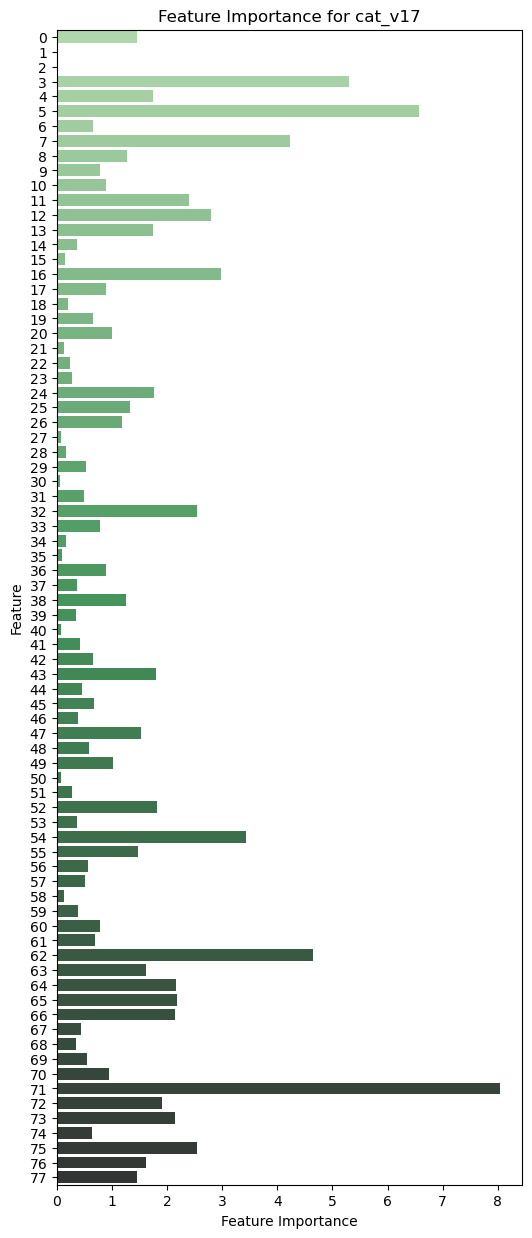

In [10]:
visualize_importance('cat_v17', feats, (6,15))

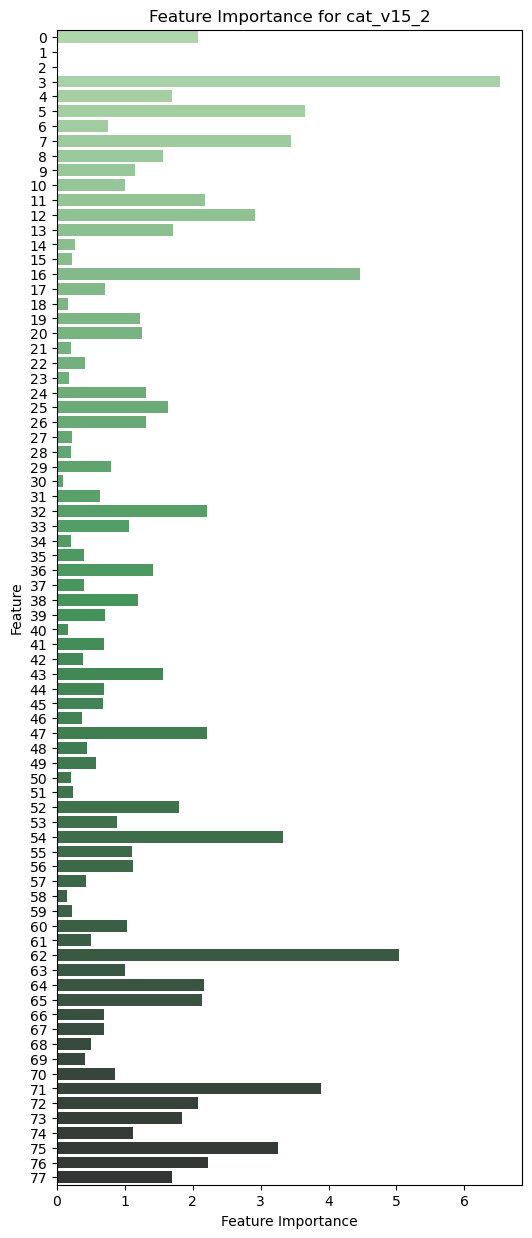

In [6]:
visualize_importance('cat_v15_2', feats, (6,15))

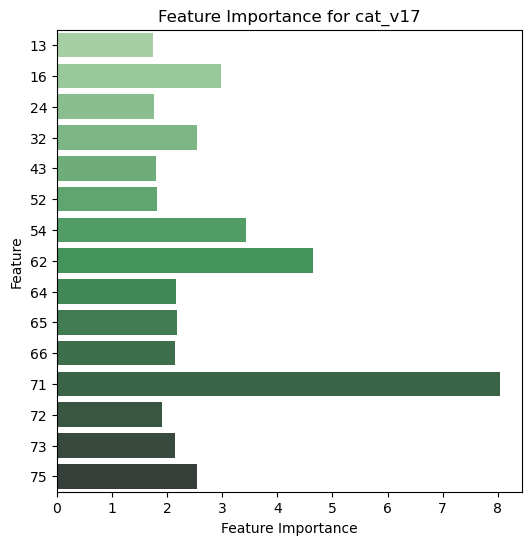

In [12]:
visualize_importance('cat_v17', tml_feats, (6,6))

# Shap Value Analysis

 
It's important not to rely solely on the shap value analysis. Shap importance illustrates how strongly a given feature affects the output of the model, but it doesn't account for the correctness of the prediction.
https://github.com/catboost/tutorials/blob/master/model_analysis/shap_values_tutorial.ipynb

In [48]:
# WARNING: this takes a while to run
# load in v17 training data and model
# (no feature selection or tuning)
# calculate shap values
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=[], 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

with open(f'../models/cat_v17.pkl', 'rb') as file:  
    model = pickle.load(file)
    
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_ss)

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


The **summary plot** provides an overview of which features are most important for the model, by plotting the SHAP values of every feature for every sample. 

This illustrates that high values for feature 71 lower the predicted class. High values for feature 62 increase the predicted class (not sure if -2 is indicative of the negative class?). In this chart, the horizontal spread shows the distribution of shap values for a single feature. The color indicates the relationship between the variables raw value and the shap value.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


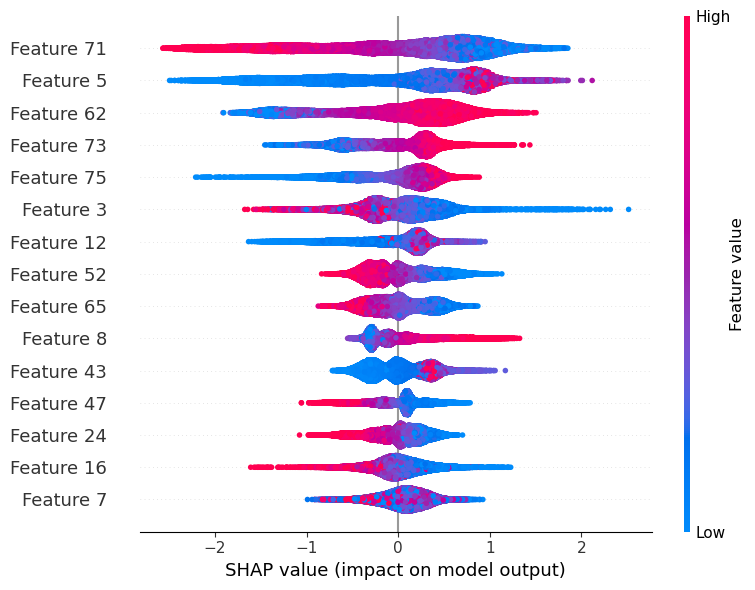

In [59]:
shap.summary_plot(shap_values, 
                  X_train_ss, 
                  max_display=15, 
                  plot_size=[8,6])

The **dependence plot** illustrates the effect of a single feature on the model output. Each dot represents a sample. The horizontal location is the actual value of the feature, and the vertical location shows what having that value did to the prediction. Vertical spread can be confusing, since it indicates that two samples with the same value had a different impact on the prediction. Vertical dispersion (lines) of the data points represents interaction effects. If an interaction feature is not specified shap will automatically select one.

**Feature 0**: The vertical lines indicate that feature 0 (DEM)'s shap value is heavily influenced by the value of feature 62. These two features have high interaction.

**Feature 1 and 2**: Sentinel 1 has no impact on the prediction?  

**Feature 13**: It makes sense that the impact of feature 13 on the prediction is most significant when the values are around .9 - 1.0, since that would indicate the high tree probability is helping with the plantation classification.  

**Features 71, 5 and 62**: these features have the greatest influence on the model, with feature 5 and 62 showing a positive linear relationship and 71 showing a negative linear relationship.

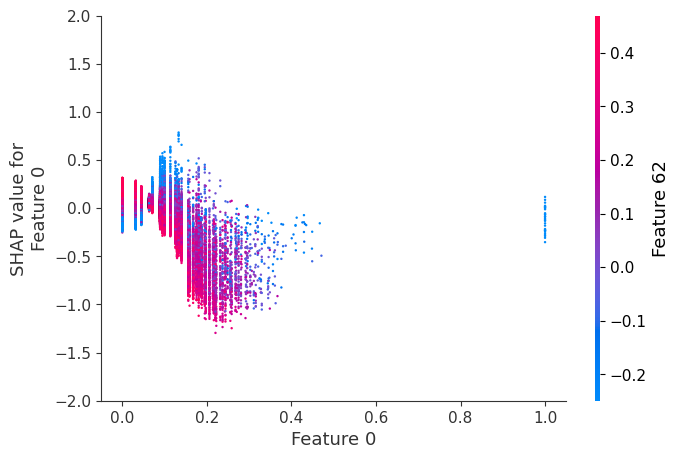

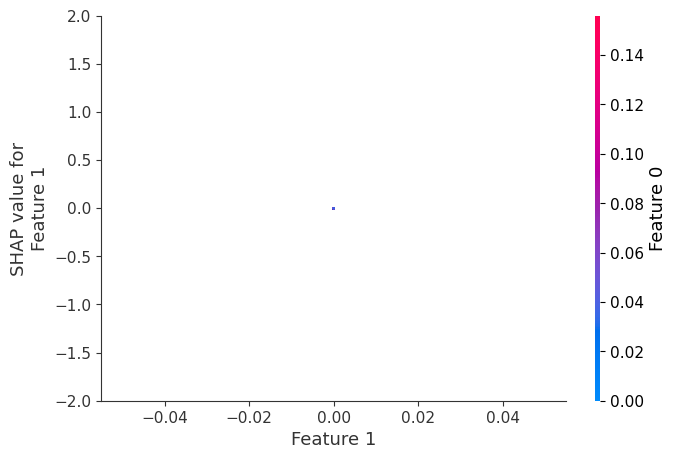

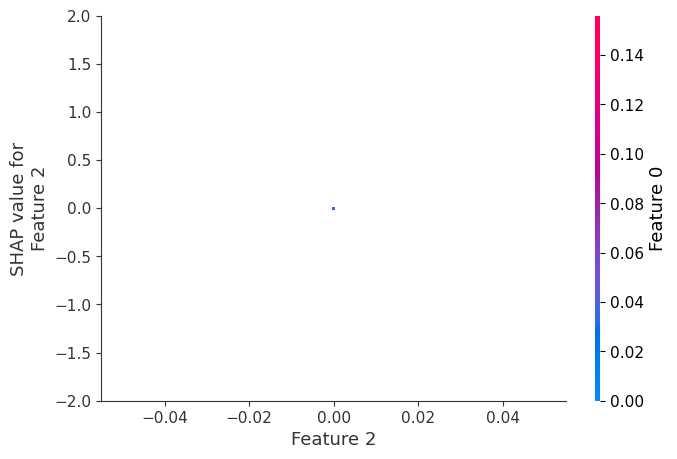

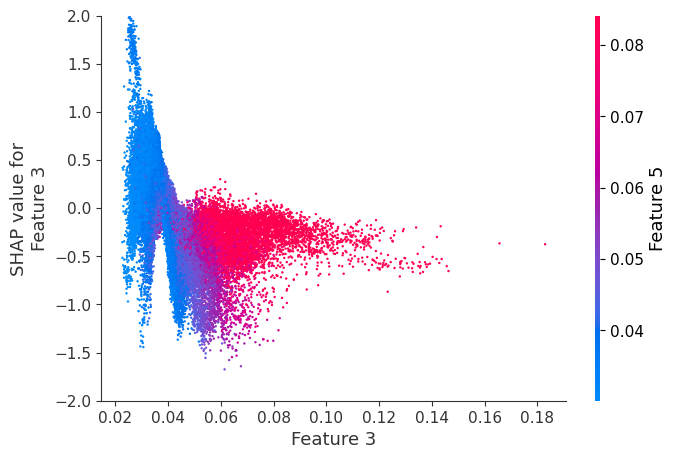

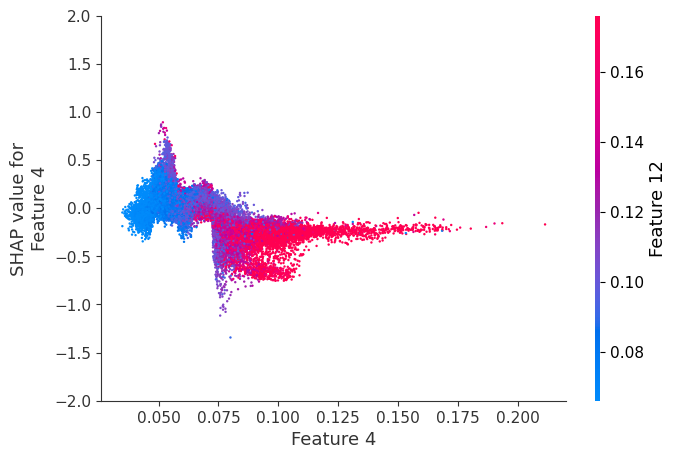

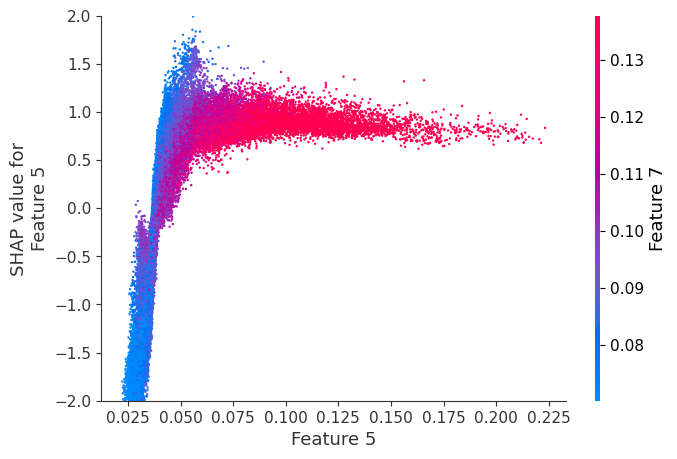

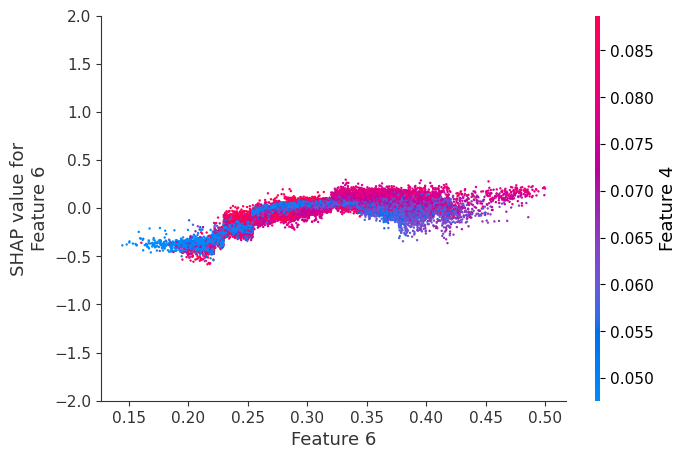

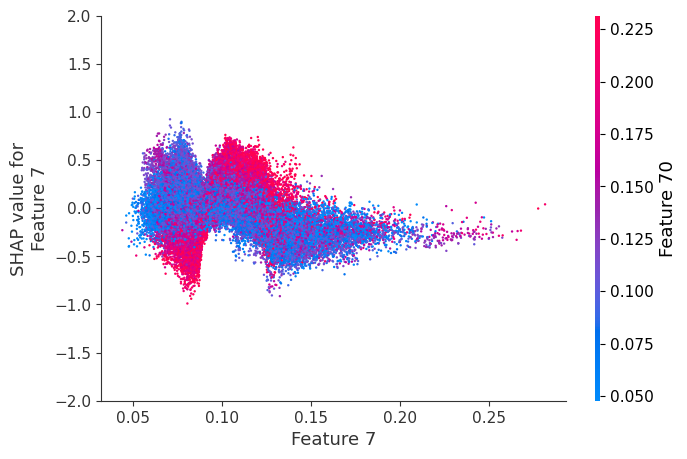

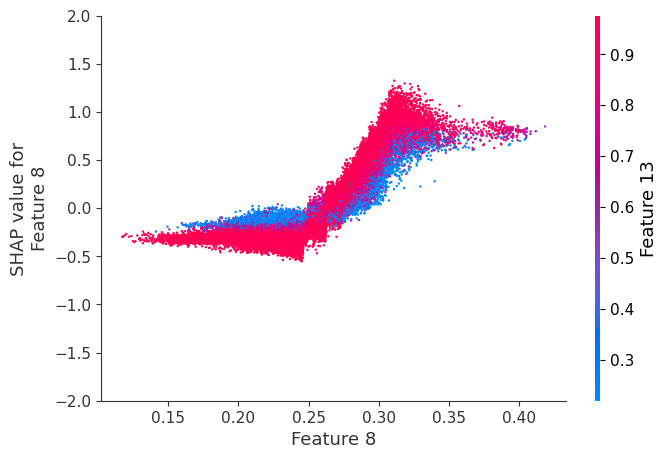

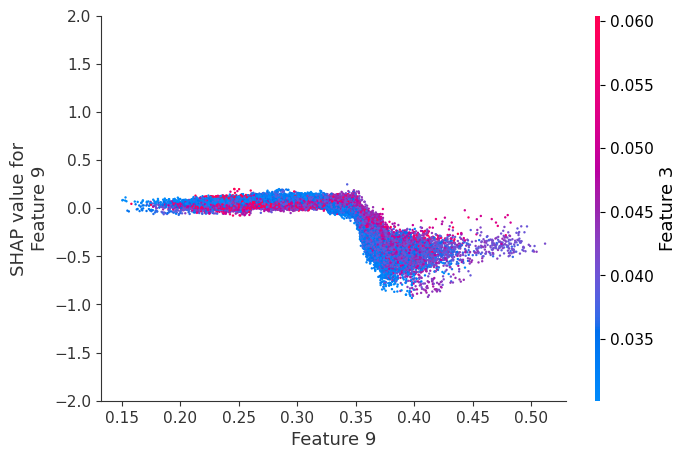

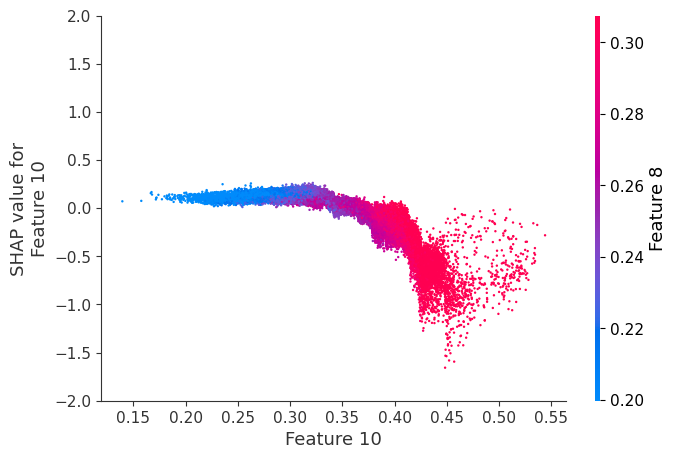

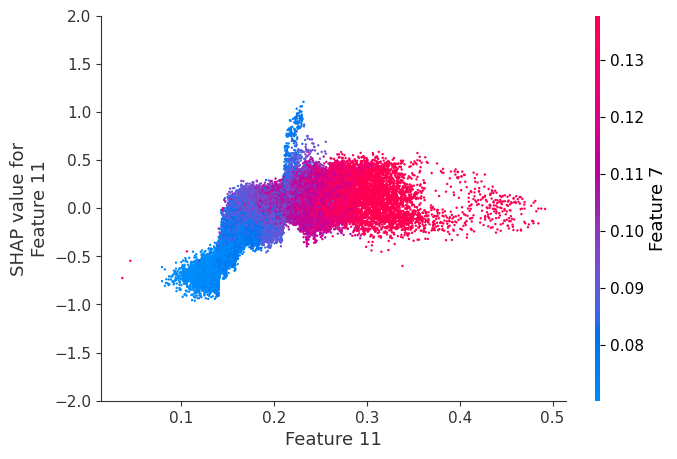

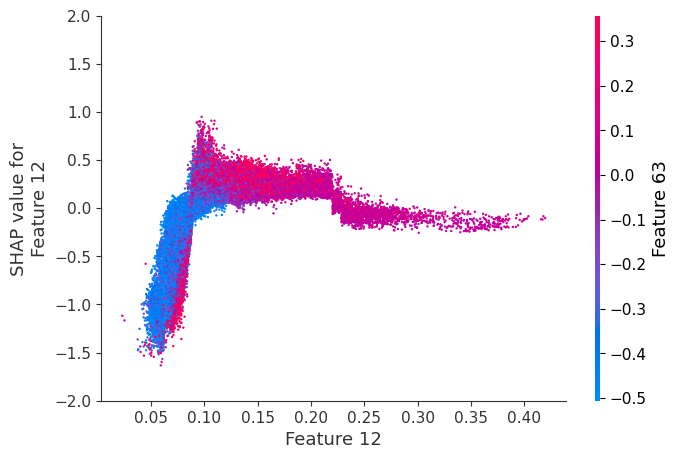

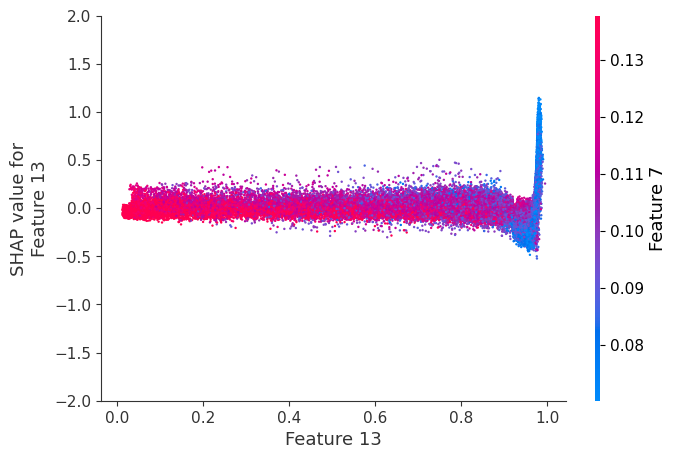

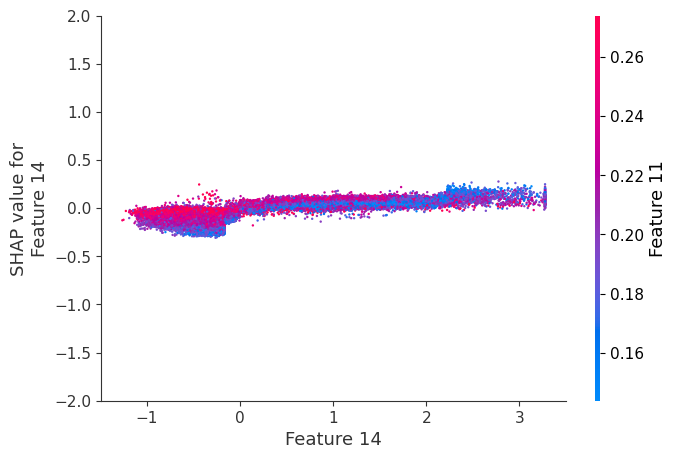

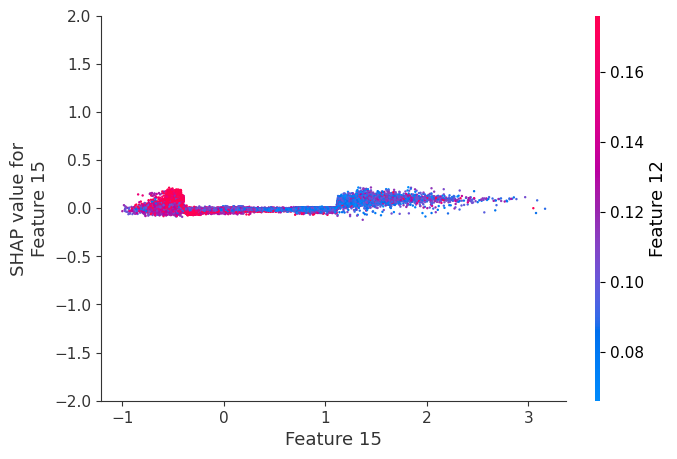

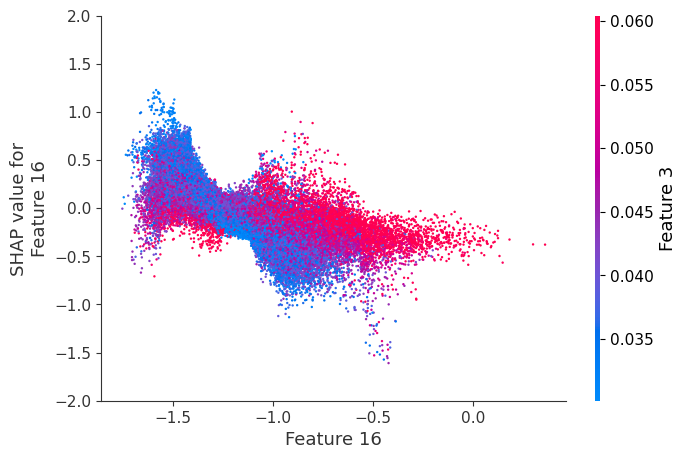

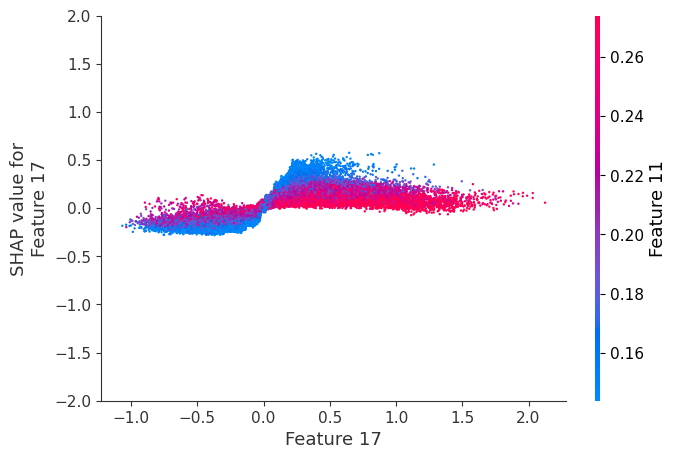

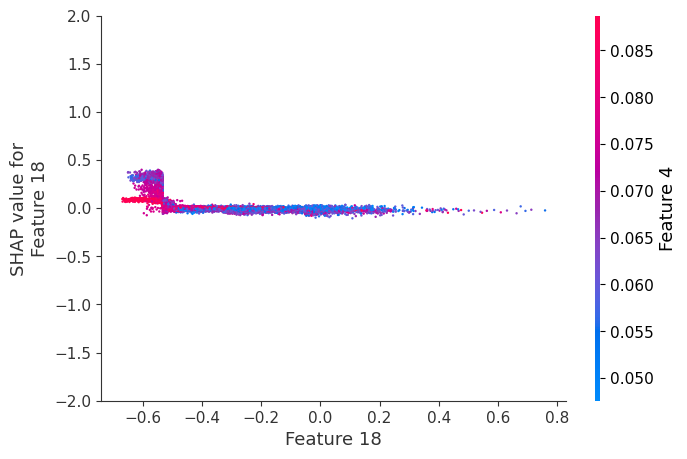

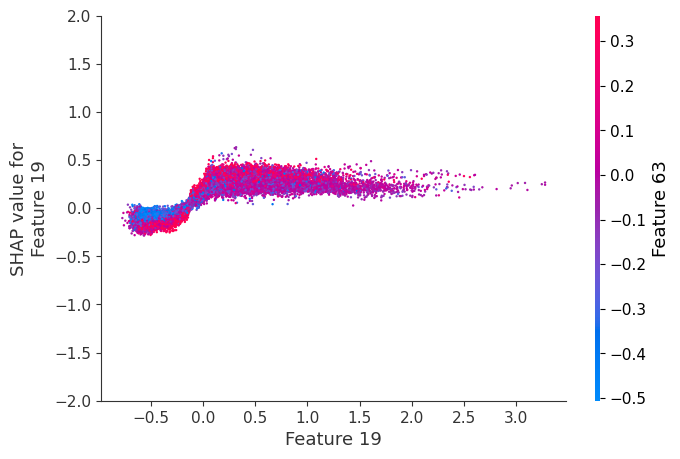

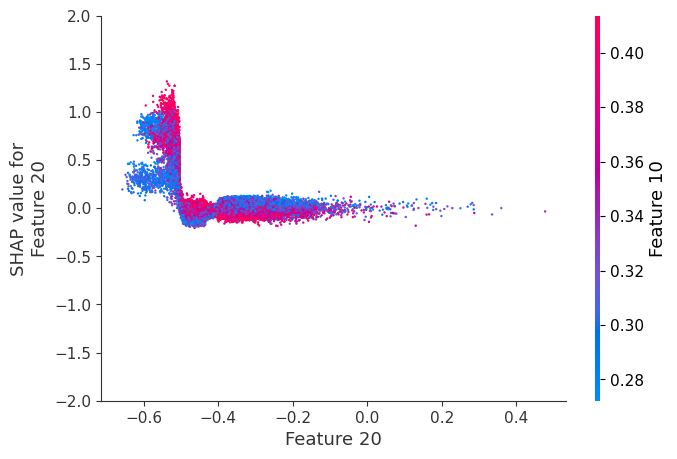

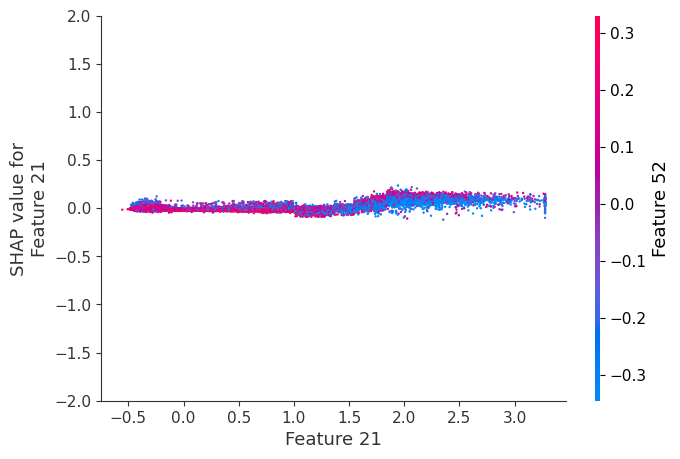

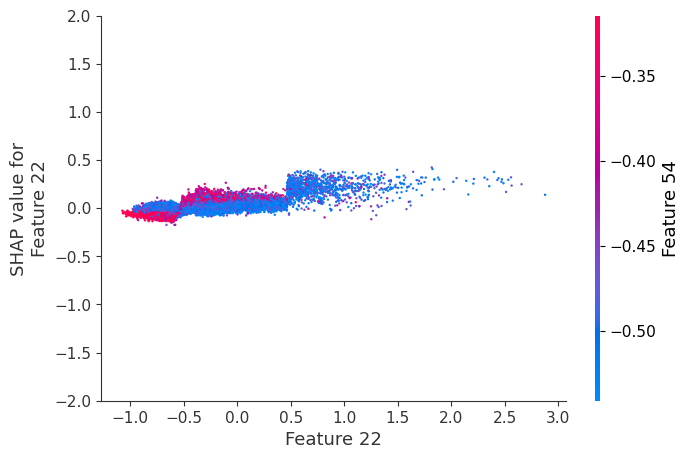

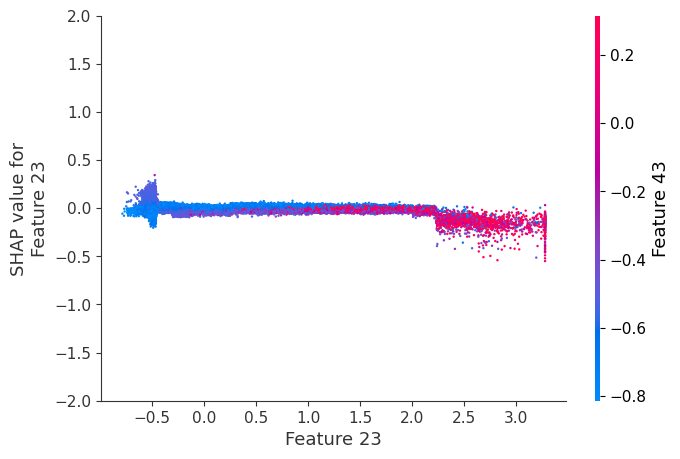

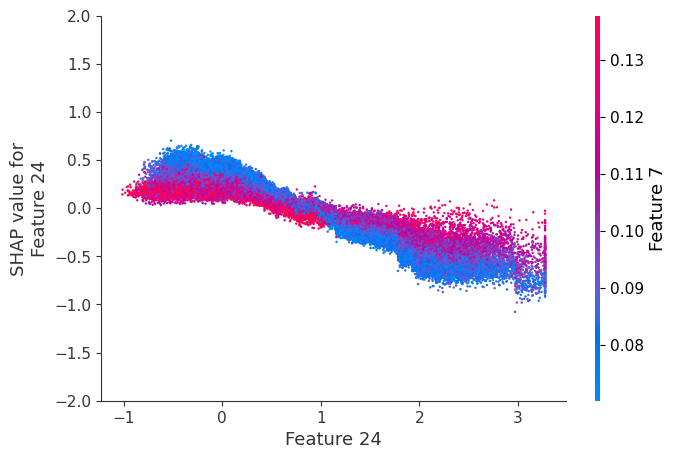

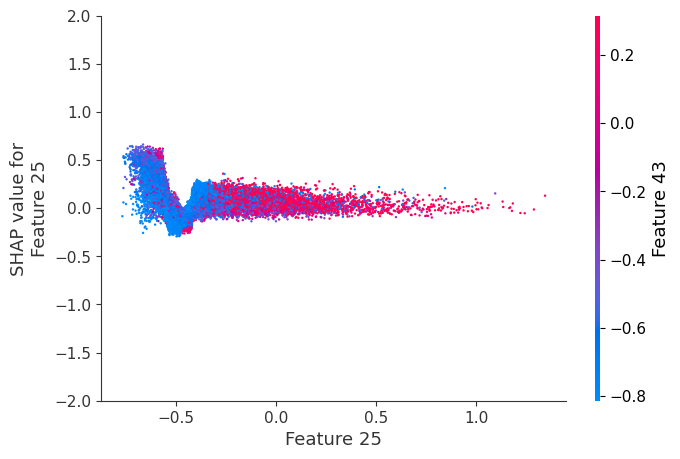

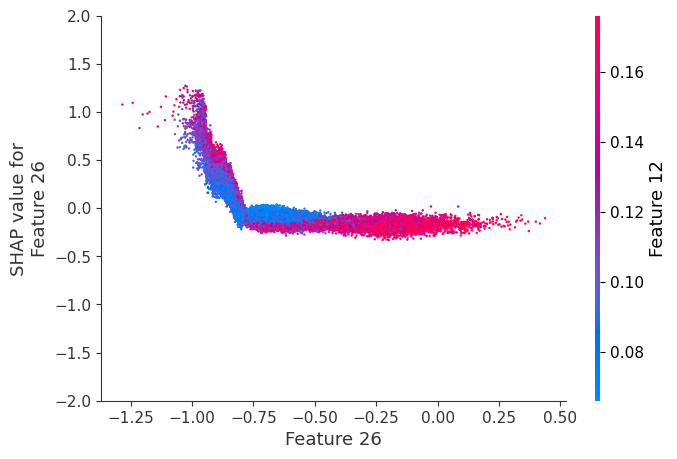

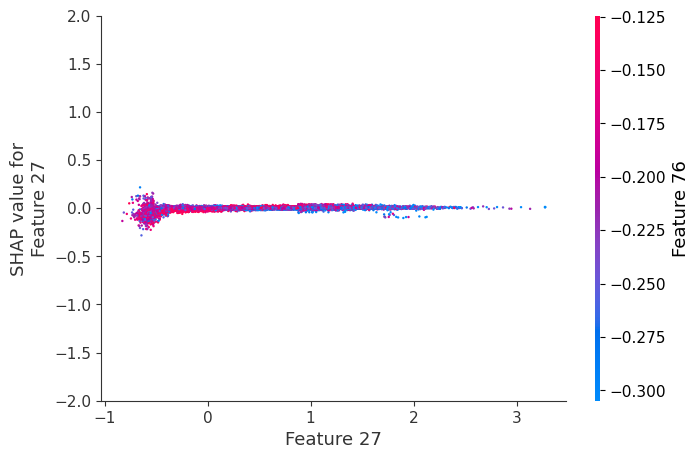

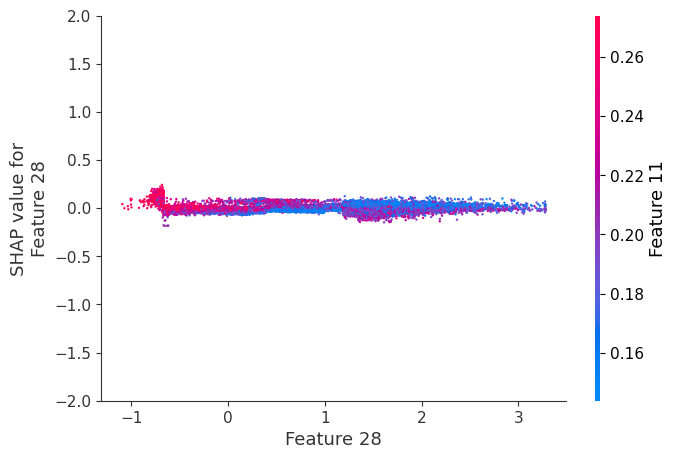

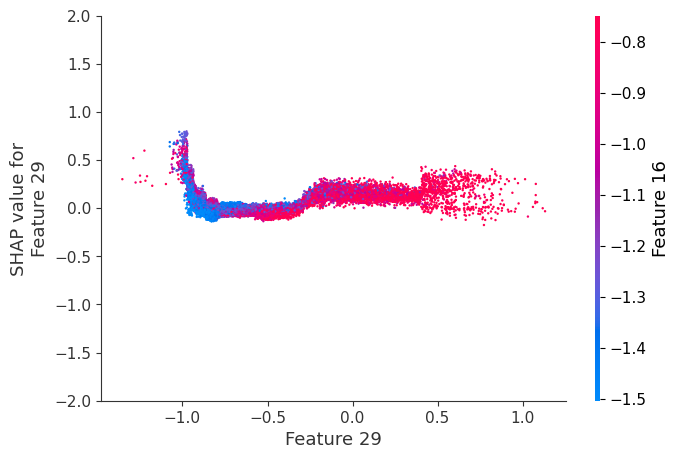

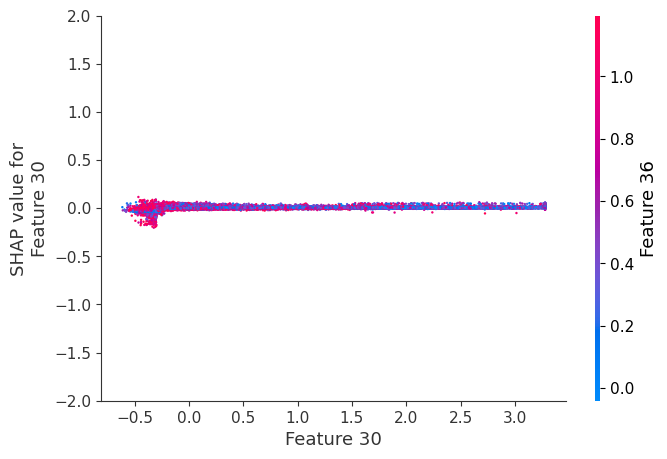

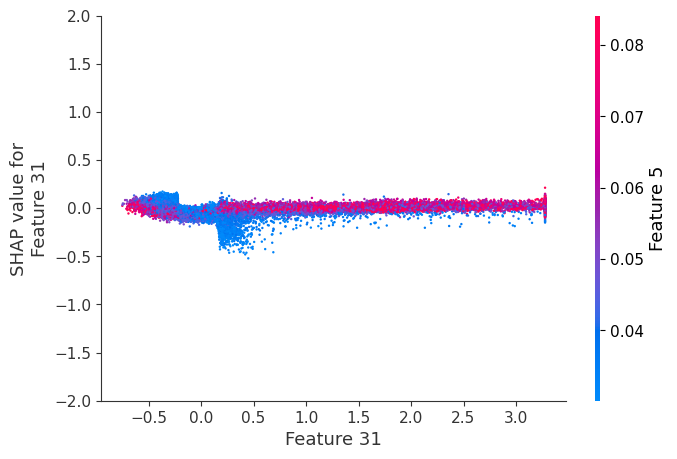

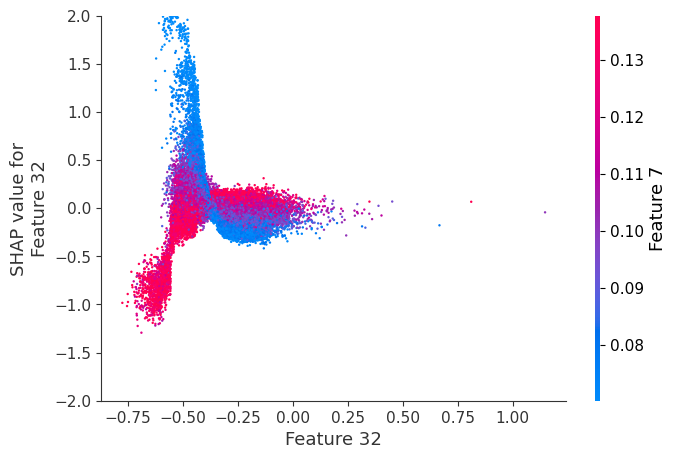

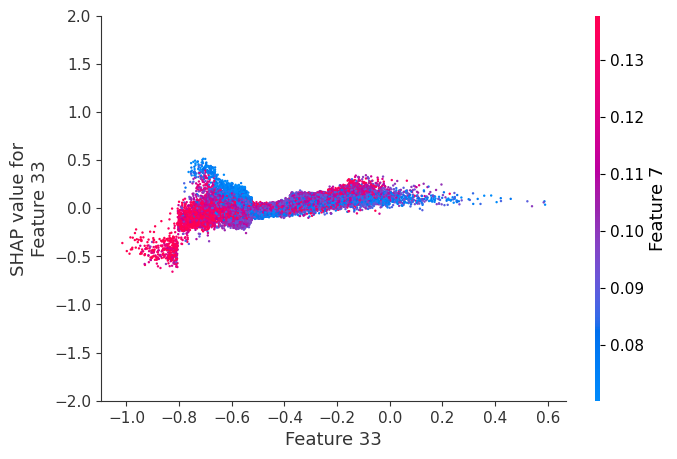

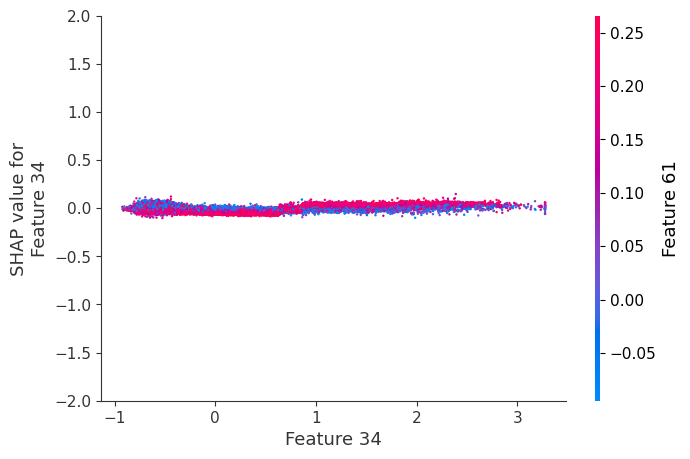

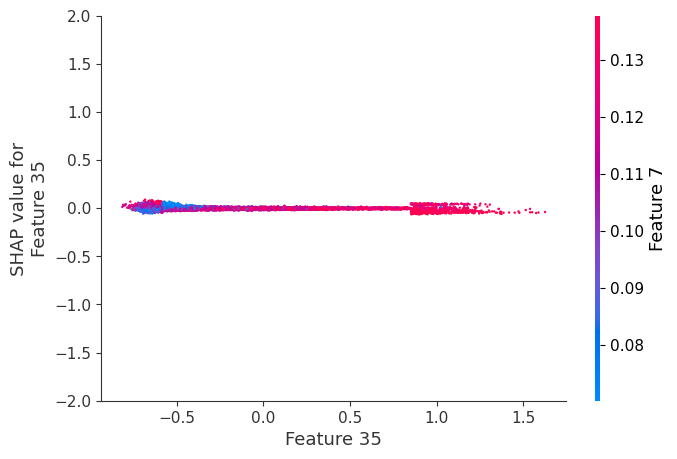

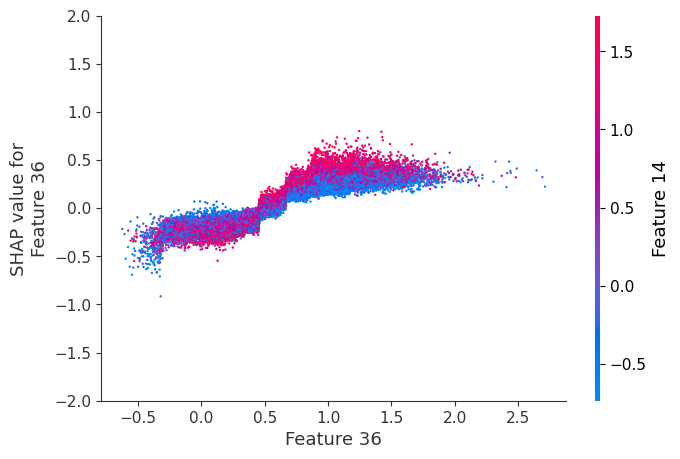

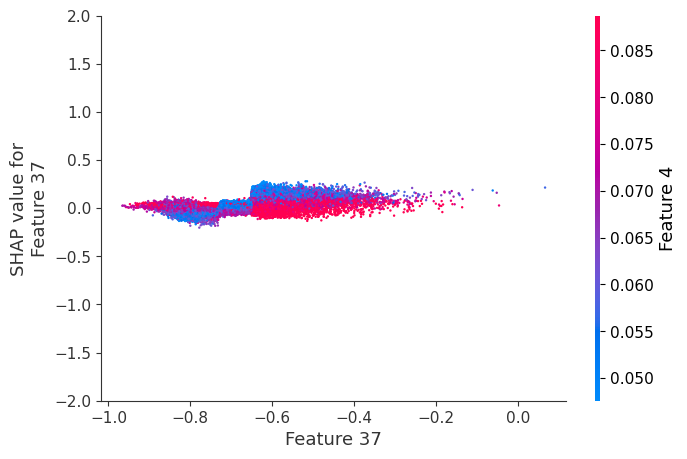

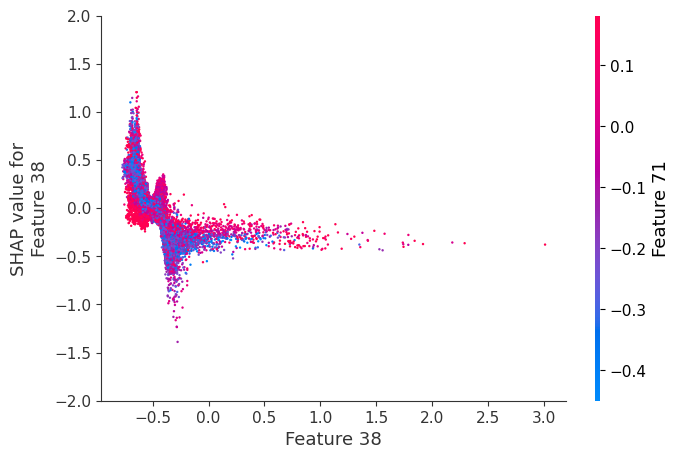

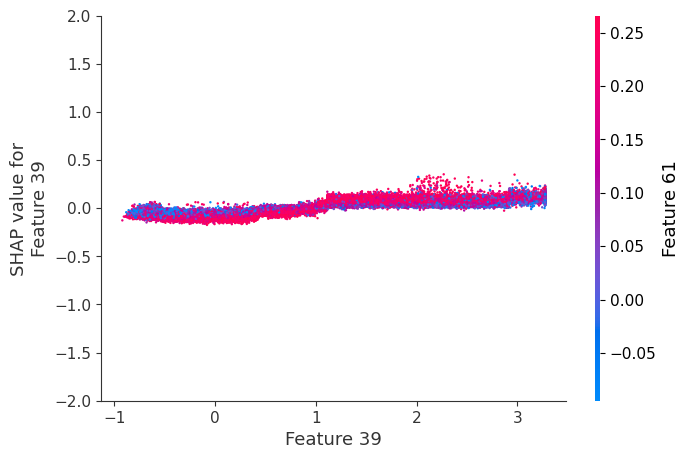

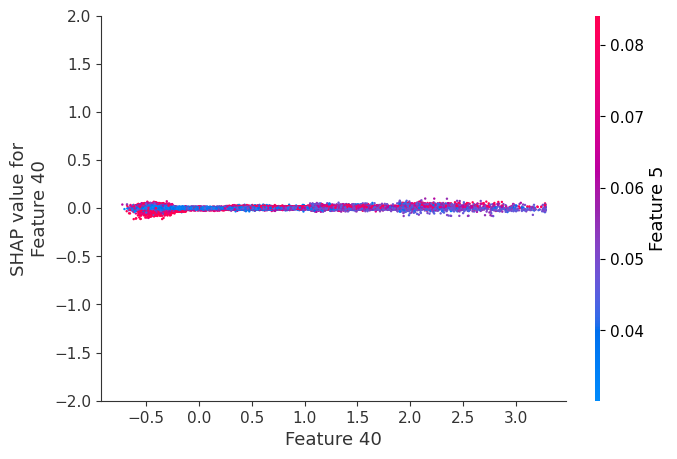

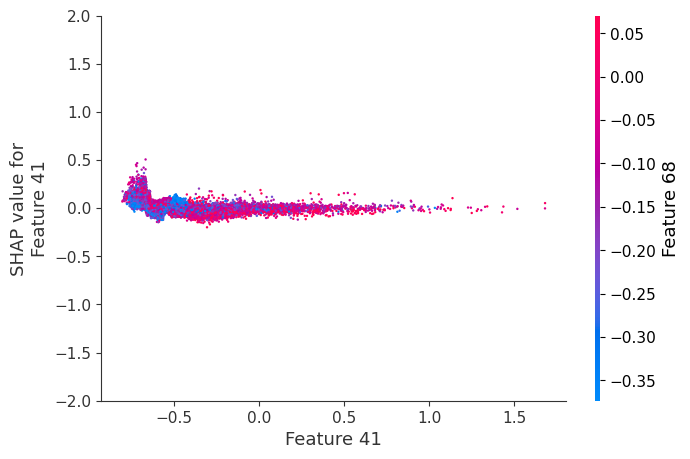

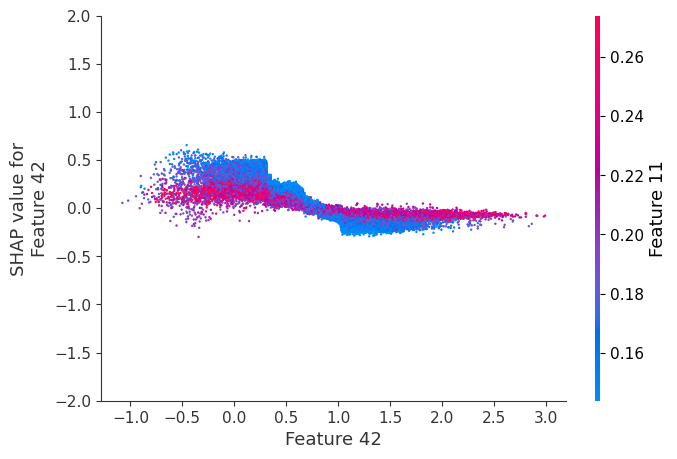

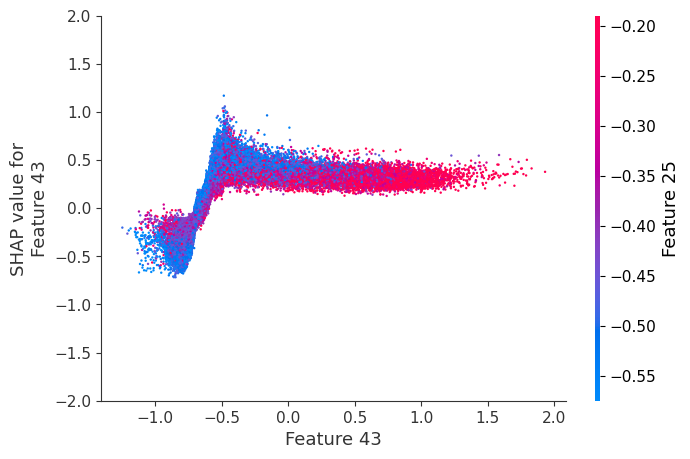

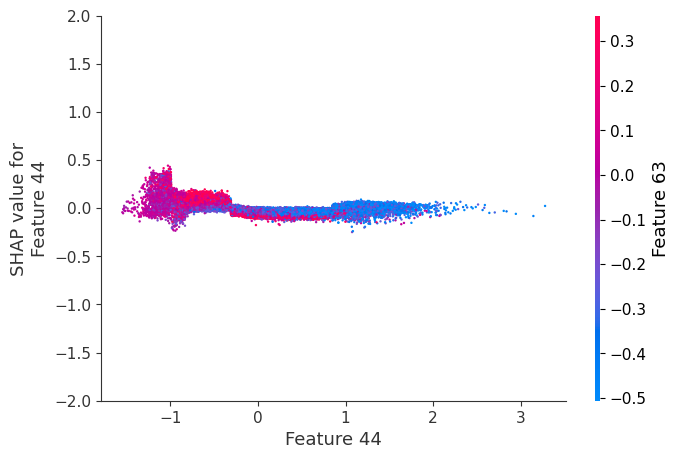

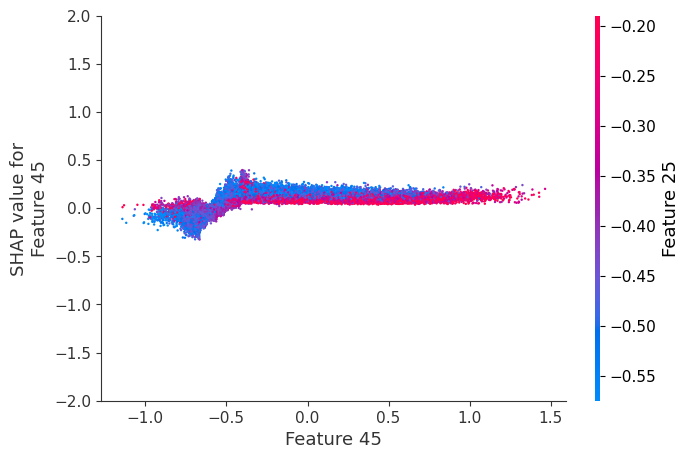

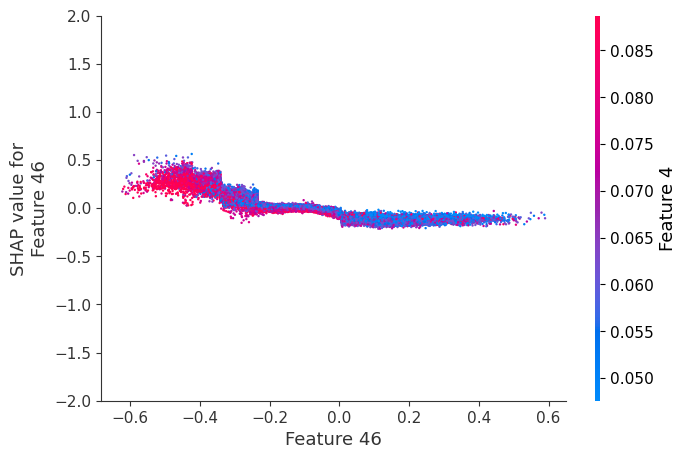

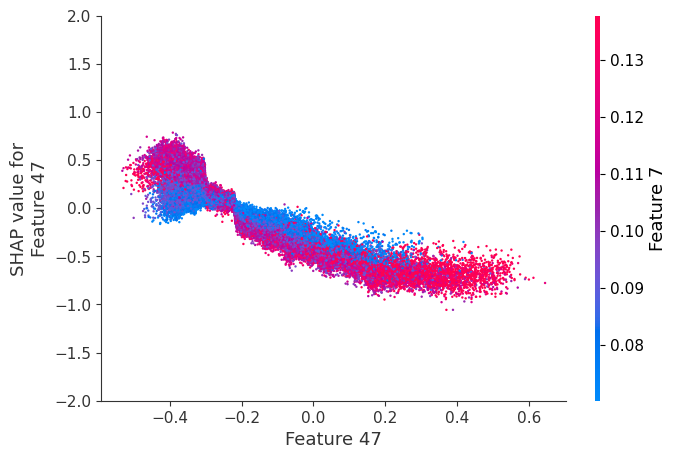

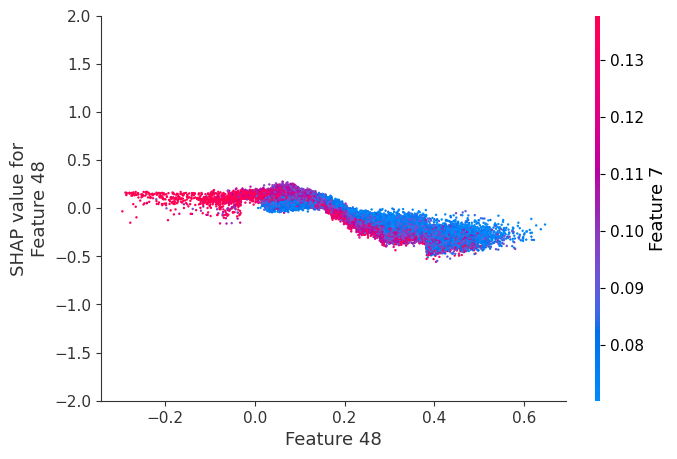

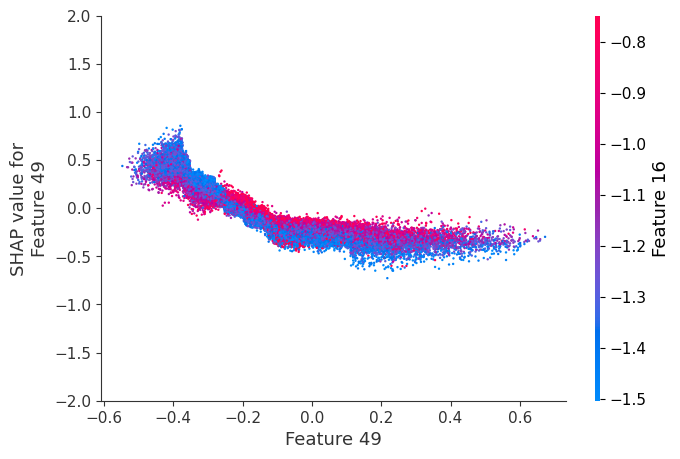

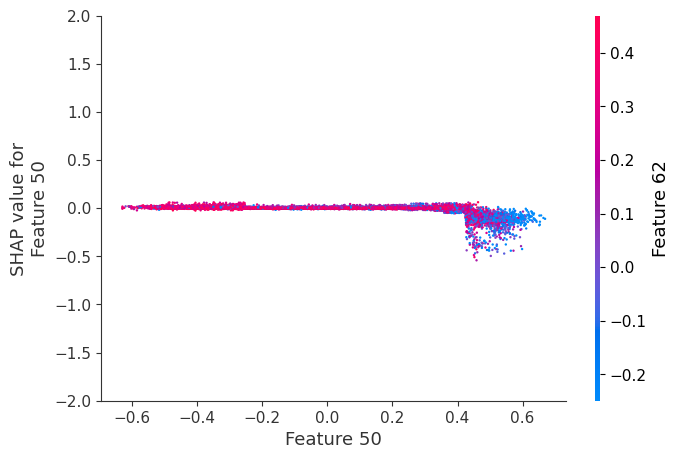

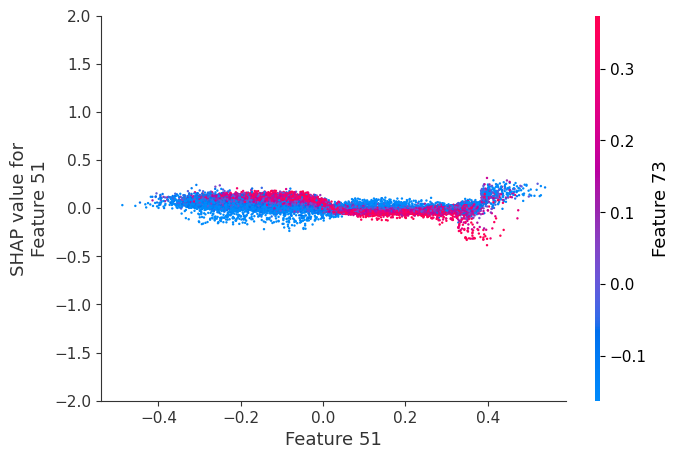

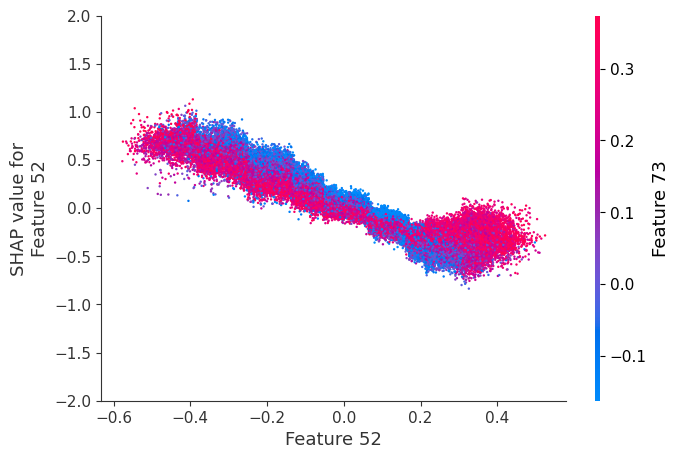

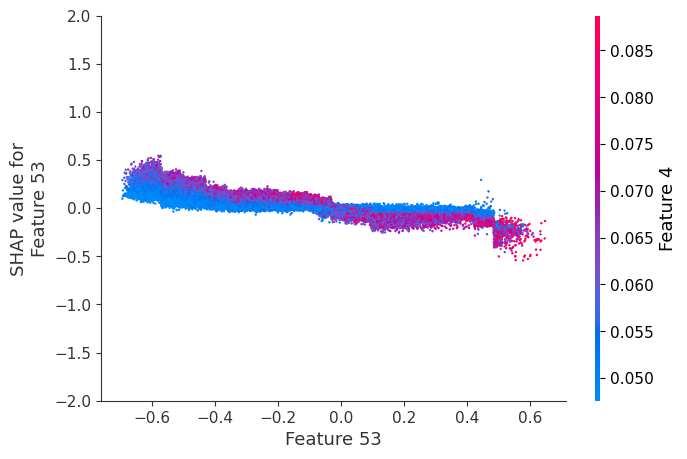

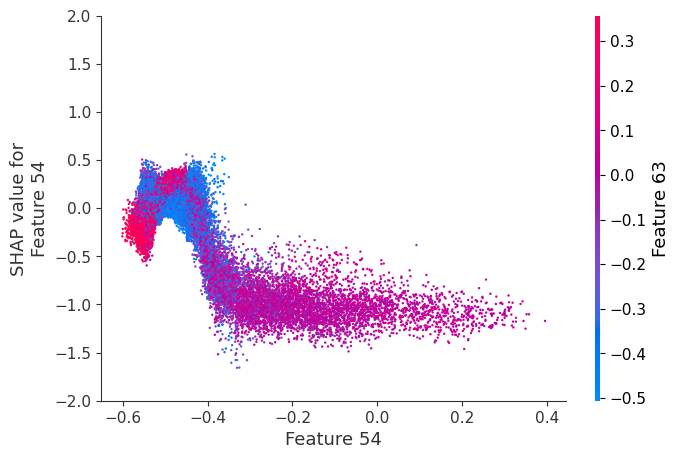

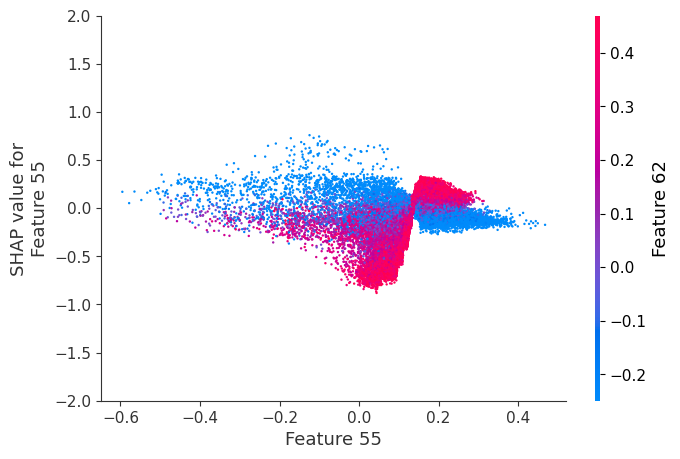

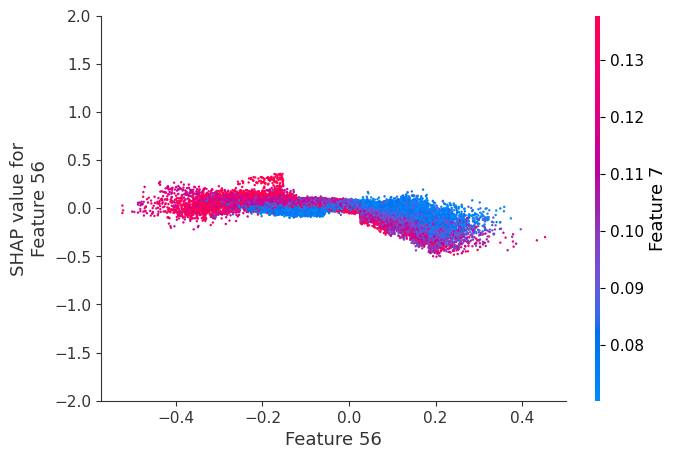

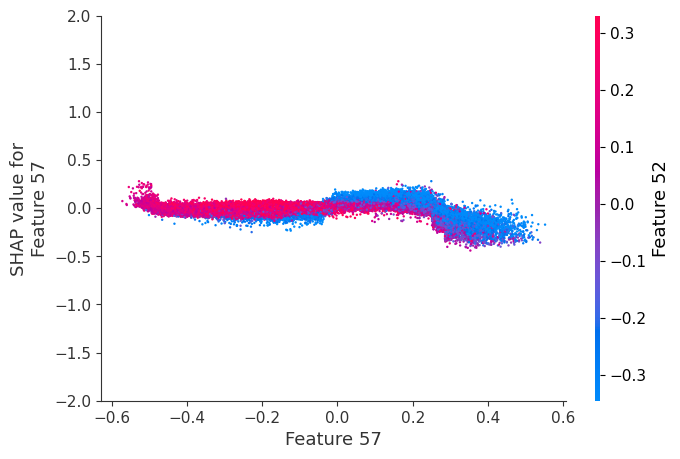

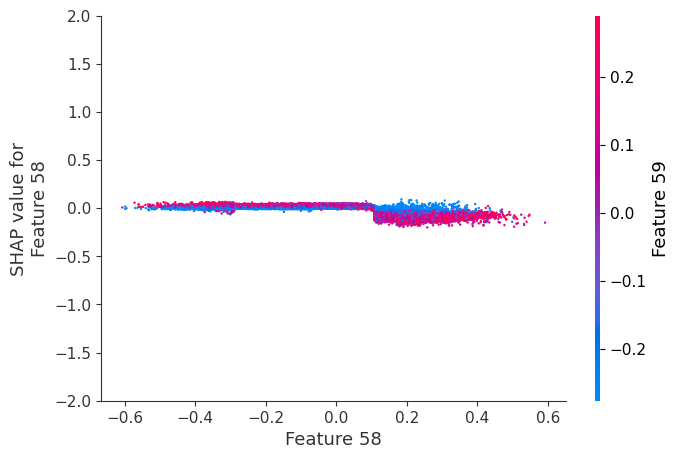

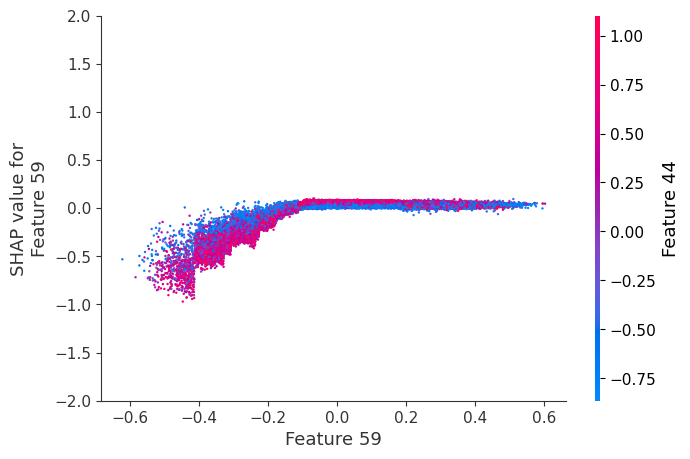

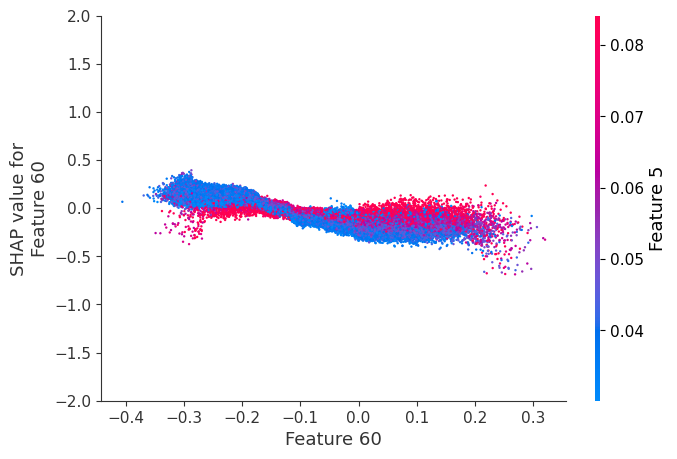

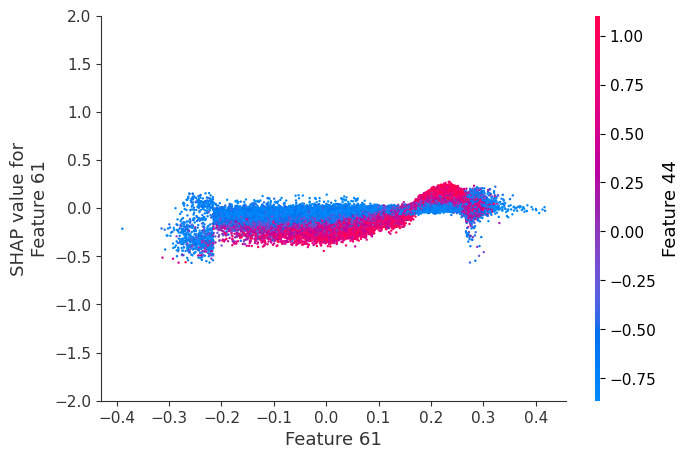

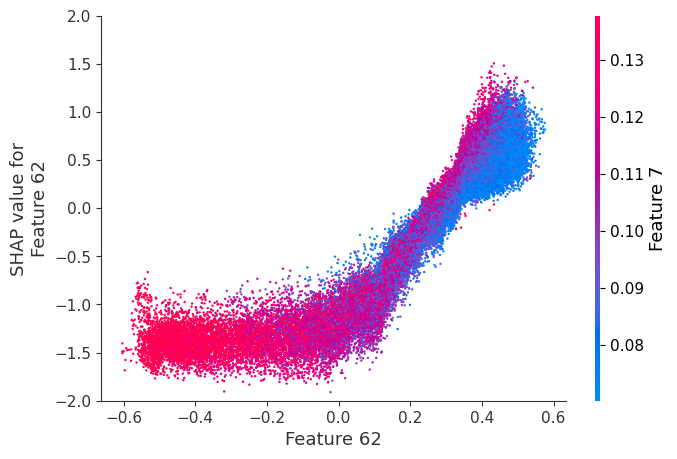

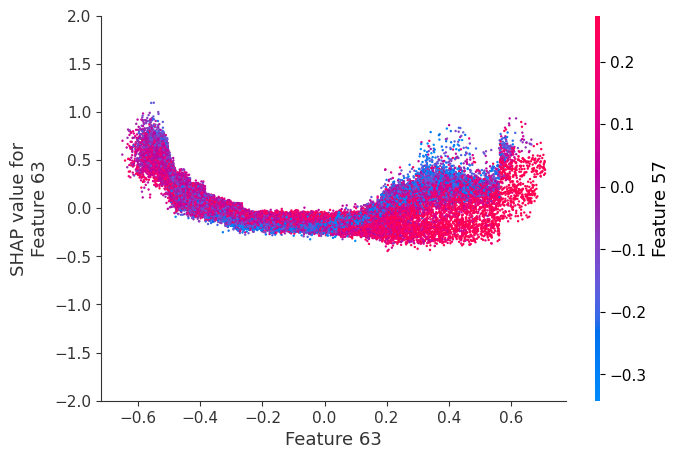

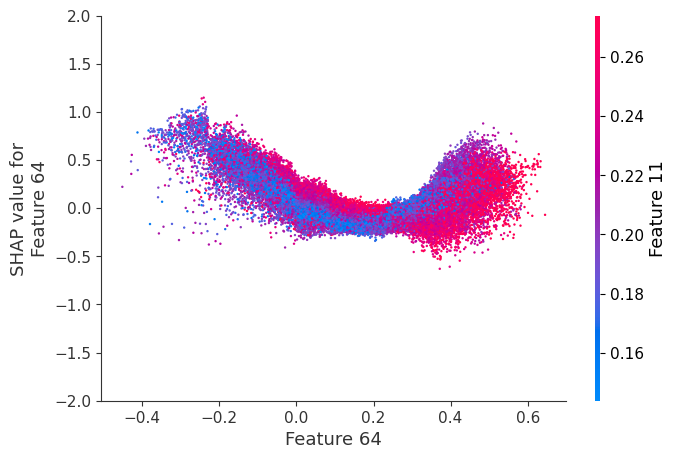

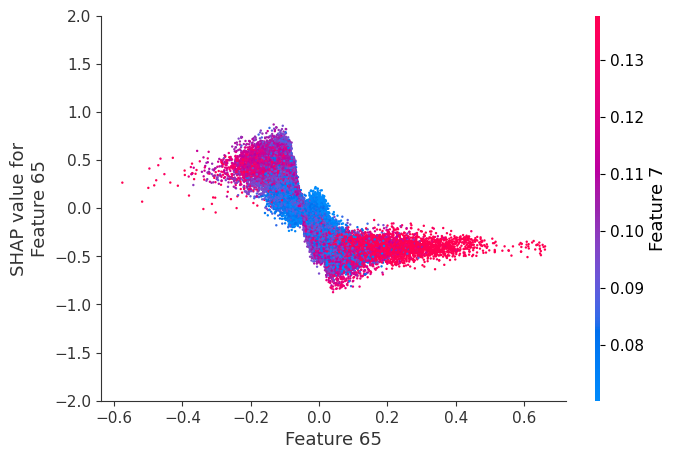

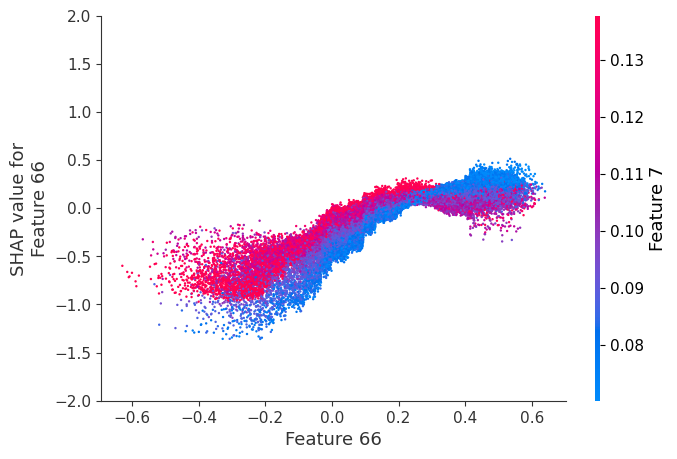

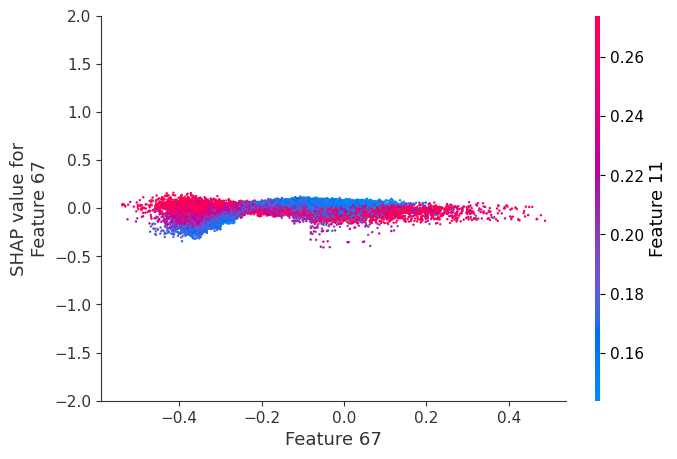

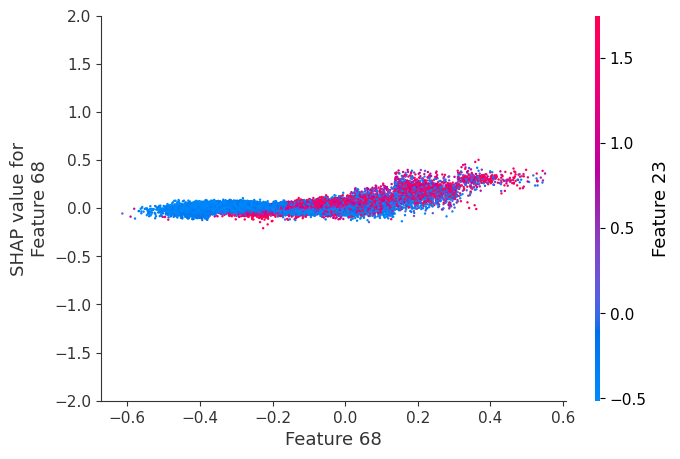

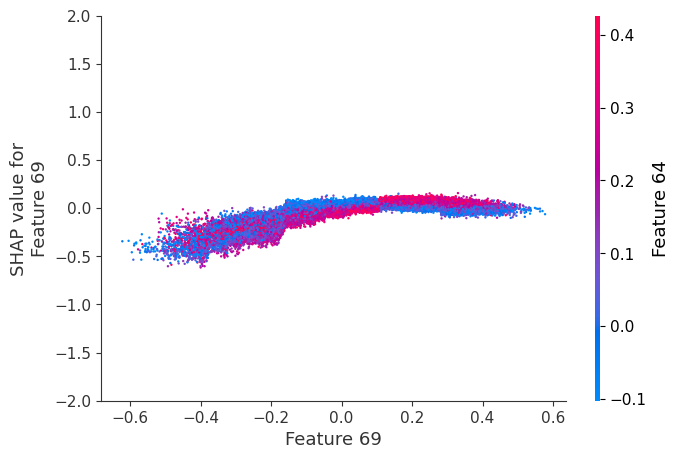

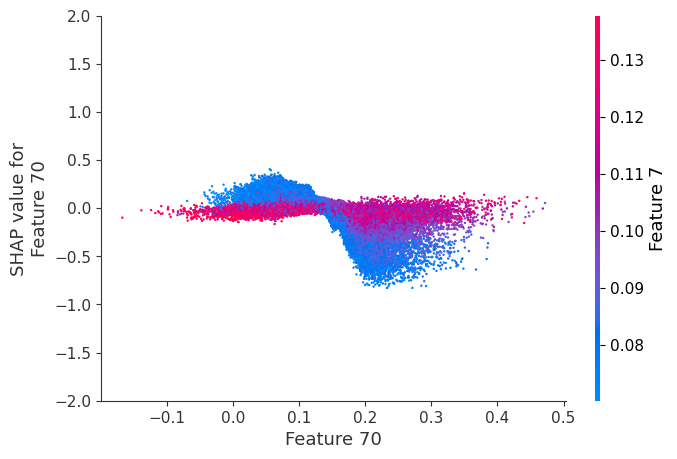

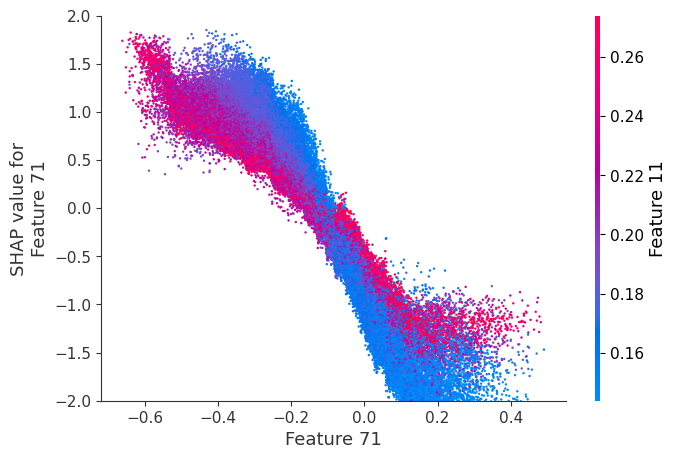

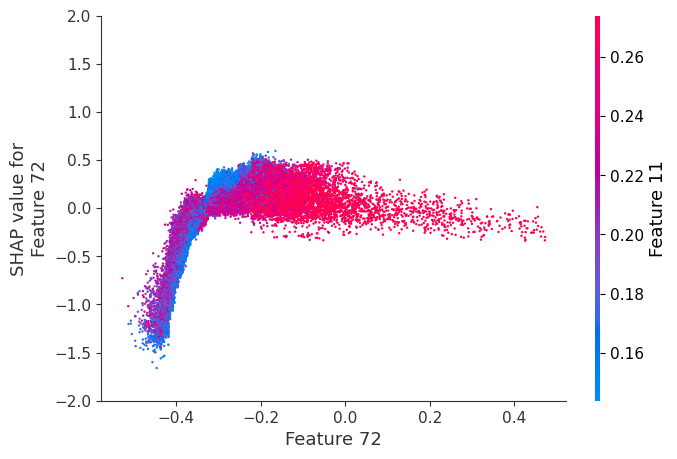

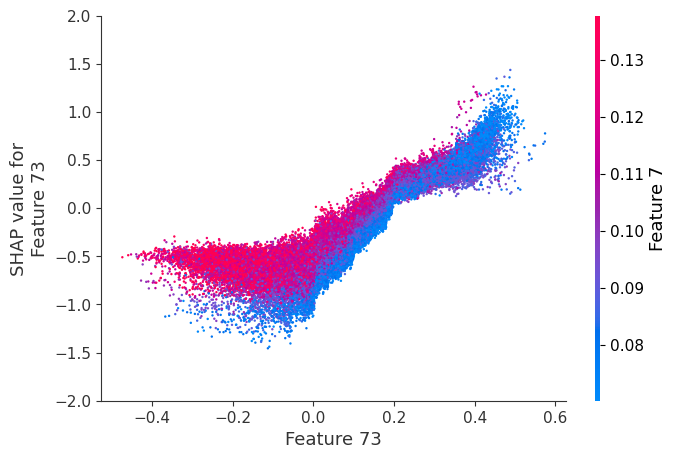

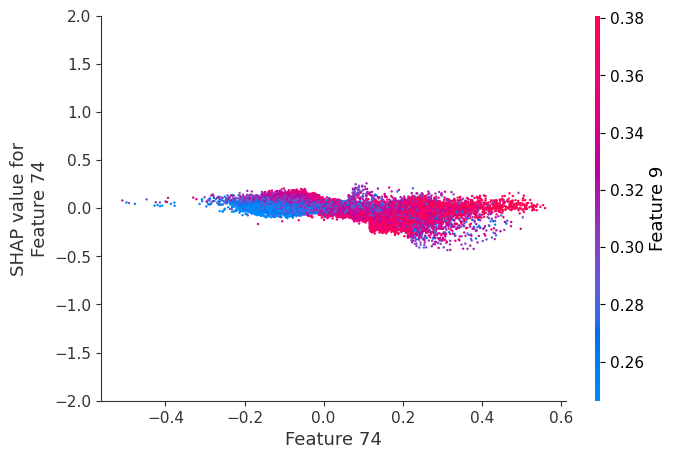

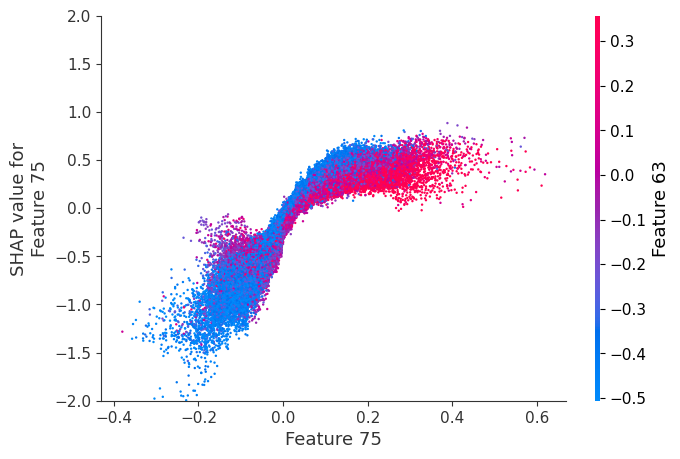

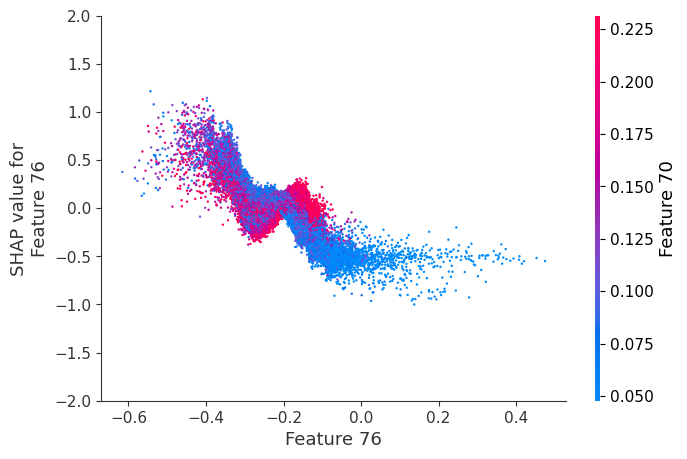

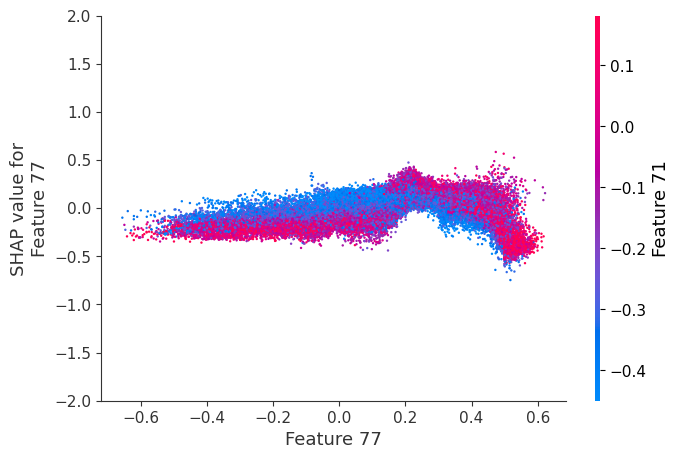

In [64]:
for feature in range(0, 78):
    shap.dependence_plot(feature, shap_values, X_train_ss, dot_size=3, ymin=-2, ymax=2)

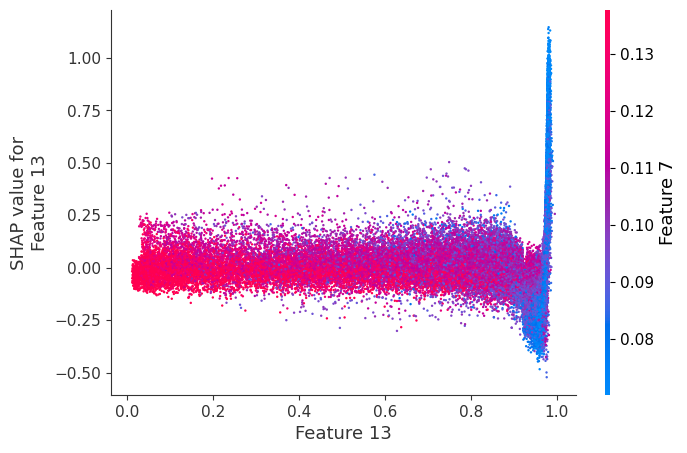

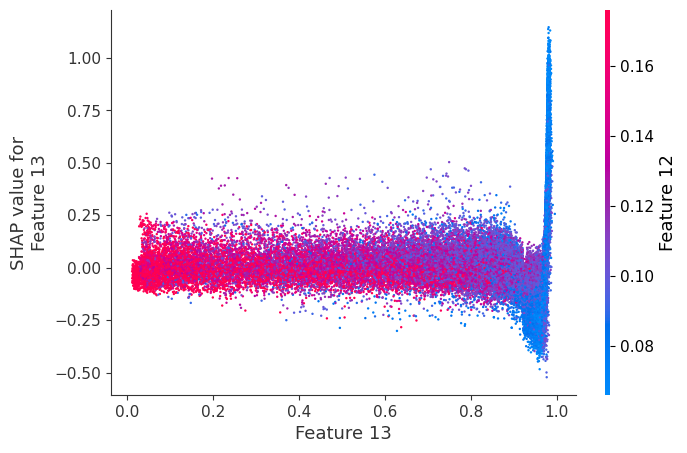

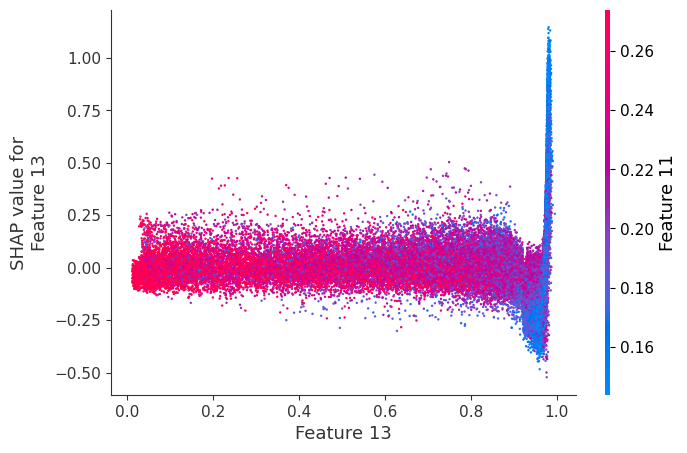

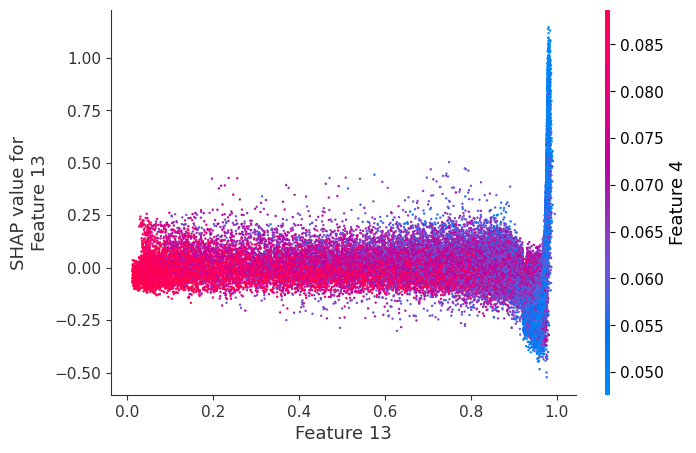

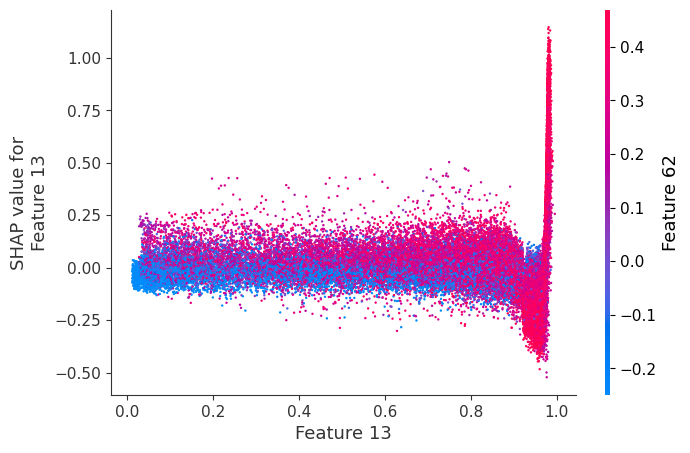

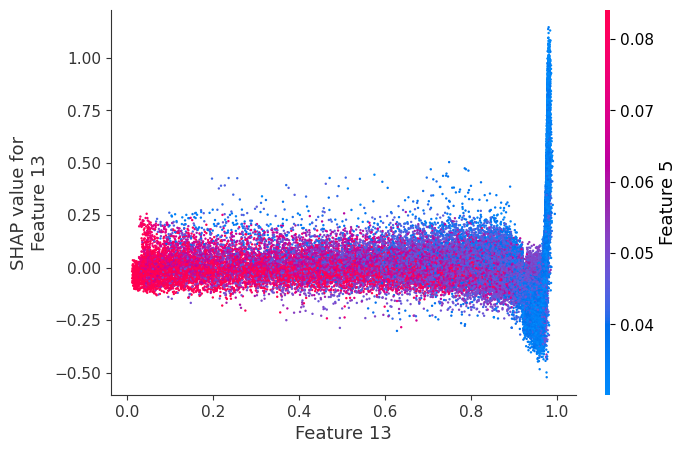

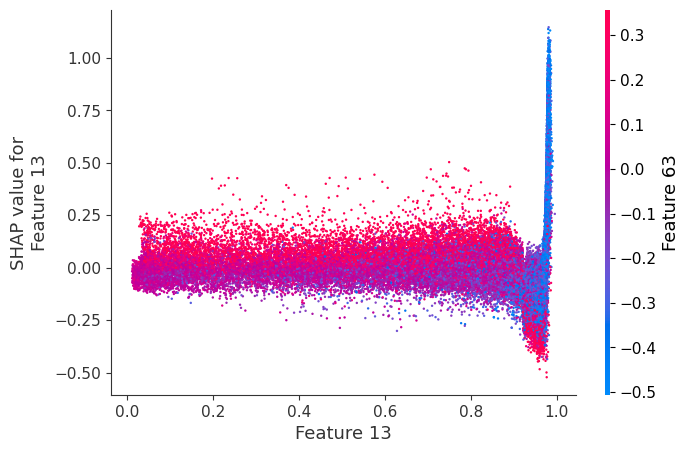

In [71]:
# we can use shap.approximate_interactions to guess which features
# may interact with the tree probability feature
inds = shap.approximate_interactions(13, shap_values, X_train_ss)

for i in range(7):
    shap.dependence_plot(13, shap_values, X_train_ss, dot_size=3, interaction_index=inds[i])

# Hyperparameter Tuning
Hyperparameter tuning was informed by [Catboost Documentation](https://catboost.ai/en/docs/concepts/parameter-tuning#iterations) and using CatBoost's built in method for randomized searches. Generally speaking, Catboost's default parameters will provide a strong result, but the tuning adjustments can bring minor improvements.

In [8]:
df = pd.read_csv('../models/mvp_scores.csv')
starter_model = df.tail(1)
starter_model

model   class      cv  train_score  test_score  roc_auc  precision  \
74  cat_v17  binary  0.8207       0.9548      0.8527   0.9168     0.8498   

    recall      f1     date  
74  0.9157  0.8815  2/13/23

In [38]:

def random_search_cat(X_train_ss, y_train, train_v):
    '''
    Performs a randomized search of hyperparameters using Catboost's built in
    random search method and plots the results, then
    and saves results to a csv file
    '''
    # Get the count of features used
    tml_feat_count = X_train_ss.shape[1] - 13
    
    iterations = [int(x) for x in np.linspace(400, 1100, 10)]            # equiv to n_estimators
    depth = [int(x) for x in np.linspace(4, 10, 4)]                      # equiv to max_depth (must be <= 16)
    l2_leaf_reg = [int(x) for x in np.linspace(2, 30, 4)]
    learning_rate = [.01, .02, .03]                                      # decrease learning rate if overfitting 

    param_dist = {'iterations': iterations,
                  'depth': depth,
                  'l2_leaf_reg': l2_leaf_reg,
                  'learning_rate': learning_rate}

    # instantiate the classifier and perform Catboost built in method for random search
    cat = CatBoostClassifier(random_seed=22, verbose=False)
    randomized_search_result = cat.randomized_search(param_dist,
                                                     X=X_train_ss,
                                                     y=y_train,
                                                     n_iter=30,
                                                     cv=3,
                                                     plot=True)
        
    rs_results = {'model': 'cat', 
                  'train_v': {train_v},
                  'class': 'binary',
                  'tml_feats': tml_feat_count,
                  'iterations': iterations,
                  'depth': depth,
                  'l2_leaf_reg': l2_leaf_reg,
                  'learning_rate': learning_rate,
                  'results': randomized_search_result,
                  'date': datetime.today().strftime('%Y-%m-%d')}

    df = pd.DataFrame([rs_results])
    
    # write scores to new line of csv
    with open('../models/random_search.csv', 'a', newline='') as f:
        f.write('\n')
        df.to_csv('../models/random_search.csv', mode='a', index=False, header=False)
    
    # save params to json file
    
    return randomized_search_result


## West Africa

In [35]:
# train a model using only 15 top feats from above
selected_feats = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=selected_feats, 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v17_fs')

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


In [42]:
## now execute the random search on v17 with 40 TML feats
rs = random_search_cat(X_train_ss, y_train, 'v17_fs')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3713504859
bestIteration = 476

0:	loss: 0.3713505	best: 0.3713505 (0)	total: 4.83s	remaining: 2m 19s

bestTest = 0.3717505403
bestIteration = 476

1:	loss: 0.3717505	best: 0.3713505 (0)	total: 9.72s	remaining: 2m 16s

bestTest = 0.3793721254
bestIteration = 632

2:	loss: 0.3793721	best: 0.3713505 (0)	total: 15.5s	remaining: 2m 19s

bestTest = 0.3798376609
bestIteration = 632

3:	loss: 0.3798377	best: 0.3713505 (0)	total: 20.9s	remaining: 2m 16s

bestTest = 0.3525048808
bestIteration = 632

4:	loss: 0.3525049	best: 0.3525049 (4)	total: 26.5s	remaining: 2m 12s

bestTest = 0.3592619583
bestIteration = 865

5:	loss: 0.3592620	best: 0.3525049 (4)	total: 34.5s	remaining: 2m 18s

bestTest = 0.4030501756
bestIteration = 865

6:	loss: 0.4030502	best: 0.3525049 (4)	total: 42.8s	remaining: 2m 20s

bestTest = 0.3312126916
bestIteration = 865

7:	loss: 0.3312127	best: 0.3312127 (7)	total: 50.5s	remaining: 2m 18s

bestTest = 0.3487206674
bestIteration = 1021

8:	loss: 0.3487207	best: 

In [45]:
rs['params']

{'depth': 10, 'l2_leaf_reg': 11, 'iterations': 1100, 'learning_rate': 0.02}

In [46]:
# now train a model with the best parameters
# manually added to run_preds script - will have to adapt moving forward
selected_feats = [0, 3, 4, 6, 7, 11, 12, 13, 16, 19, 20, 23, 25, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64]

X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15', 'v17'], 
                    classes='binary', 
                    drop_prob=False, 
                    drop_feats=False, 
                    feature_select=selected_feats, 
                    verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v17_tuned')

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Plot id 170078 has no cloud free imagery and will be removed.
Plot id 170098 has no cloud free imagery and will be removed.
Plot id 1700100 has no cloud free imagery and will be removed.


In [42]:
## for binary classification, use scale_pos_weight 
## for multi class classification, use class_weights
# to get the scale pos weight you would use sum(negative class) // sum(positive class)
# this will be the weight for class 1
# https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance
class_count = {0.0: 30139, 1.0: 79033}
scale_pos = class_count[0] / class_count[1]
scale_pos

0.3813470322523503

# Comparison with Baselines

In [47]:
scores = pd.read_csv('../models/mvp_scores.csv')
v17_scores = scores[70:]
v17_scores

model   class  tml_feats      cv  train_score  test_score  \
70         cat_v17  binary       65.0  0.8207       0.9548      0.8527   
71  cat_v17_scaled  binary       65.0  0.8208       0.9556      0.8501   
72      cat_v17_fs  binary       15.0  0.8095       0.9422      0.8417   
73      cat_v17_fs  binary       40.0  0.8197       0.9547      0.8514   
74      cat_v17_fs  binary       40.0  0.8197       0.9547      0.8514   
75   cat_v17_tuned  binary       40.0  0.8162       0.9614      0.8500   

    roc_auc  precision  recall      f1        date  
70   0.9168     0.8498  0.9157  0.8815     2/13/23  
71   0.9158     0.8471  0.9146  0.8795     2/14/23  
72   0.9038     0.8421  0.9052  0.8725     2/15/23  
73   0.9150     0.8494  0.9137  0.8804     2/15/23  
74   0.9150     0.8494  0.9137  0.8804     2/15/23  
75   0.9172     0.8441  0.9192  0.8800  2023-02-15

In [ ]:
[0 3 4 6 7 11 12 13 16 19 20 23 25 29 30 32 34 35 36 39 41 42 43 44 47 48 49 50 51 52 53 56 57 58 59 60 61 62 63 64]

## Check consistency across regions
Are the same features important for the catboost model in West Africa and South America? This section compares the top 15 most important features across regions.

In [4]:
# are the same features important for catboost in west africa?
feats_v11, tml_feats_v11 = feature_selection('cat_v11', 15)

Feature Id  Importances
1           71     7.007700
3           16     5.586165
6           54     3.646442
7           64     3.270772
8           76     3.261219
10          62     3.126678
11          75     2.760612
12          72     2.658921
13          74     2.524666
14          13     2.363818
15          32     2.300606
16          77     1.736156
17          20     1.692248
20          25     1.179787
23          47     1.101969

In [5]:
# how about south america? (v9)
feats_v9, tml_feats_v9 = feature_selection('cat_v9', 15)

Feature Id  Importances
2           16     5.736892
4           33     3.903781
9           51     2.772934
10          62     2.696718
11          13     2.542589
12          72     2.429293
13          24     2.274026
17          71     1.643682
18          20     1.578809
19          47     1.521576
20          77     1.480200
21          75     1.435575
22          68     1.306945
23          25     1.284786
25          38     1.209190

In [6]:
# what are the common best features across three regions
list(v09['Feature Id'])

[16, 33, 51, 62, 13, 72, 24, 71, 20, 47, 77, 75, 68, 25, 38]

In [7]:
list(v10['Feature Id'])

[62, 71, 74, 32, 64, 54, 33, 38, 46, 16, 77, 36, 60, 19, 13]

In [8]:
list(v11['Feature Id'])

[71, 16, 54, 64, 76, 62, 75, 72, 74, 13, 32, 77, 20, 25, 47]

In [9]:
# check latin america similarities, then including africa
first_set = set(list(v09['Feature Id'])).intersection(set(list(v10['Feature Id'])))    
result_set = first_set.intersection(set(list(v11['Feature Id'])))
print(f'common feats in central/south america: {first_set}')
print(f'common feats in all pilots: {result_set}')

common feats in central/south america: {33, 38, 71, 13, 77, 16, 62}
common feats in all pilots: {71, 77, 13, 16, 62}
